# A nonlinear Poisson equation #

We shall now address how to solve nonlinear PDEs. We will see that
nonlinear problems can be solved just as easily as linear problems in
FEniCS, by simply defining a nonlinear variational problem and calling
the `solve` function. When doing so, we will encounter a subtle
difference in how the variational problem is defined.

## PDE problem ##

As a model problem for the solution of nonlinear PDEs, we
take the following nonlinear Poisson equation:

\begin{equation}
-\nabla\cdot\left(q(u)\nabla u\right) = f,
\end{equation}

in $\Omega$, with $u=u_D$ on the boundary $\partial\Omega$.
The coefficient $q = q(u)$ makes the equation nonlinear (unless $q(u)$
is constant in $u$).

### Variational formulation ###

As usual, we multiply our PDE by a test function $v\in\hat V$,
integrate over the domain, and integrate the second-order derivatives
by parts. The boundary integral arising from integration by parts
vanishes wherever we employ Dirichlet conditions. The resulting
variational formulation of our model problem becomes: find $u \in V$
such that

\begin{equation}
F(u; v) = 0 \ \ \ \ \forall v \in \hat{V},
\label{eq-poisson0-nonlinear1}
\end{equation}

where

\begin{equation}
F(u; v) = \int_\Omega (q(u)\nabla u\cdot \nabla v - fv) dx,
\label{eq-poisson0-nonlinear2}
\end{equation}

and

\begin{align*}
     V      &= \{v \in H^1(\Omega) : v = u_D \mbox{ on } \partial\Omega\},\\
    \hat{V} &= \{v \in H^1(\Omega) : v = 0 \mbox{ on } \partial\Omega\}.
\end{align*}

The discrete problem arises as usual by restricting $V$ and $\hat V$
to a pair of discrete spaces. As before, we omit any subscript on
the discrete spaces and discrete solution.
The discrete nonlinear problem is then written as: find $u\in V$ such that

\begin{equation}
  F(u; v) = 0 \ \ \ \ \  \forall v \in \hat{V},
\label{eq-poisson0-nonlinear-d}
\end{equation}

with $u = \sum_{j=1}^N U_j \phi_j$. Since $F$ is nonlinear in
$u$, the variational statement gives rise to a system of
nonlinear algebraic equations in the unknowns $U_1,\ldots,U_N$.

## FEniCS implementation ##

### Test problem ###

To solve a test problem, we need to choose the right-hand side $f$,
the coefficient $q(u)$ and the boundary value $u_D$.  Previously, we
have worked with manufactured solutions that can be reproduced without
approximation errors. This is more difficult in nonlinear problems,
and the algebra is more tedious. However, we may utilize SymPy for
symbolic computing and integrate such computations in the FEniCS
solver. This allows us to easily experiment with different
manufactured solutions. The forthcoming code with SymPy requires some
basic familiarity with this package. In particular, we will use the
SymPy functions `diff` for symbolic differentiation and `ccode` for
C/C++ code generation.

We take $q(u) = 1 + u^2$ and define a two-dimensional manufactured
solution that is linear in $x$ and $y$:

In [1]:
# Warning: from fenics import * will import both `sym` and
# `q` from FEniCS. We therefore import FEniCS first and then
# overwrite these objects.
from fenics import *

def q(u):
    "Return nonlinear coefficient"
    return 1 + u**2

Note: Define symbolic coordinates as required in `Expression` objects
Note that we would normally write `x, y = sym.symbols('x, y')`, but
if we want the resulting expressions to have valid syntax for
FEniCS `Expression` objects, we must use `x[0]` and `x[1]`.
This is easily accomplished with `sympy` by defining the names of `x` and
`y` as `x[0]` and `x[1]`: `x, y = sym.symbols('x[0], x[1]')`.

In [2]:
# Use SymPy to compute f from the manufactured solution u
import sympy as sym
x, y = sym.symbols('x[0], x[1]')
u = 1 + x + 2*y

f = - sym.diff(q(u)*sym.diff(u, x), x) - sym.diff(q(u)*sym.diff(u, y), y)
f = sym.simplify(f)

Turning the expressions for `u` and `f` into C or C++ syntax for
FEniCS `Expression` objects needs two steps. First, we ask for the C
code of the expressions:

In [3]:
u_code = sym.printing.ccode(u)
f_code = sym.printing.ccode(f)

print('u =', u_code)
print('f =', f_code)

u = x[0] + 2*x[1] + 1
f = -10*x[0] - 20*x[1] - 10


In some cases, one will need to edit the result to match the required
syntax of `Expression` objects, but not in this case. (The primary
example is that `M_PI` for $\pi$ in C/C++ must be replaced by `pi` for
`Expression` objects.) 

After having defined the mesh, the function space, and the boundary,
we define the boundary value `u_D` as

In [4]:
u_D = Expression(u_code, degree=1)

Similarly, we define the right-hand side function as

In [5]:
f = Expression(f_code, degree=1)

*Warning*: Name clash between FEniCS and program variables
In a program like the one above, strange errors may occur due to
name clashes. If you define `sym` and `q` prior to doing
`from fenics import *`, the latter statement will also import
variables with the names `sym` and `q`, overwriting
the objects you have previously defined! This may lead to strange
errors. The safest solution is to do `import fenics` instead of
`from fenics import *` and then prefix all FEniCS
object names by `fenics`. The next best solution is to do
`from fenics import *` first and then define your own variables
that overwrite those imported from `fenics`. This is acceptable
if we do not need `sym` and `q` from `fenics`.

## FEniCS implementation ##

A solver for the nonlinear Poisson equation is as easy to
implement as a solver for the linear Poisson equation.
All we need to do is to state the formula for $F$ and call
`solve(F == 0, u, bc)` instead of `solve(a == L, u, bc)` as we did
in the linear case. Here is a minimalistic code:

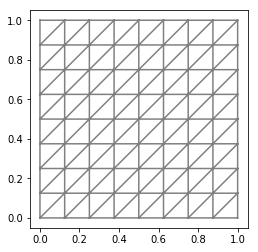

In [6]:
%matplotlib inline

n = 16

mesh = UnitSquareMesh(8, 8)
plot(mesh)

V = FunctionSpace(mesh, 'P', 1)
u = Function(V)
v = TestFunction(V)

In [7]:
def boundary(x, on_boundary):
    return on_boundary

u_D = Expression(u_code, degree=1)
bc = DirichletBC(V, u_D, boundary)

In [8]:
f = Expression(f_code, degree=1)
F = q(u)*dot(grad(u), grad(v))*dx - f*v*dx

solve(F == 0, u, bc)

We can examine the solution at the vertices:

In [9]:
import numpy as np

def print_max_error():
    u_e = interpolate(u_D, V)

    u0_at_vertices = u_e.compute_vertex_values()
    u_at_vertices = u.compute_vertex_values()
    coor = V.mesh().coordinates()

    print('Max error is: ', np.max(u0_at_vertices - u_at_vertices))

def print_errors():
    u_e = interpolate(u_D, V)

    u0_at_vertices = u_e.compute_vertex_values()
    u_at_vertices = u.compute_vertex_values()
    coor = V.mesh().coordinates()

    for i, x in enumerate(coor):
        print('vertex %2d (%9g,%9g): error=%g' %
              (i, x[0], x[1],
               u0_at_vertices[i] - u_at_vertices[i]))

print_max_error()

Max error is:  0.0


The major difference from a linear problem is that the unknown function
`u` in the variational form in the nonlinear case
must be defined as a `Function`, not as a `TrialFunction`. In some sense
this is a simplification from the linear case where we must define `u`
first as a `TrialFunction` and then as a `Function`.


### Newton's method ###

The `solve` function takes the nonlinear equations, derives symbolically
the Jacobian matrix, and runs a Newton method to compute the solution.

When we run the code, FEniCS reports on the progress of the Newton
iterations. With $2\cdot(8\times 8)$ cells, we reach convergence in eight
iterations with a tolerance of $10^{-9}$, and the error in the
numerical solution is about $10^{-16}$. These results bring evidence
for a correct implementation. Thinking in terms of finite differences
on a uniform mesh, $\mathsf{P}_1$ elements mimic standard
second-order differences, which compute the derivative of a linear or
quadratic function exactly. Here, $\nabla u$ is a constant vector, but
then multiplied by $(1+u^2)$, which is a second-order polynomial in
$x$ and $y$, which the divergence "difference operator" should
compute exactly. We can therefore, even with $\mathcal{P}_1$
elements, expect the manufactured $u$ to be reproduced by the
numerical method. With a nonlinearity like $1+u^4$, this will not be
the case, and we would need to verify convergence rates instead.

The current example shows how easy it is to solve a nonlinear problem
in FEniCS. However, experts on the numerical solution of nonlinear
PDEs know very well that automated procedures may fail for nonlinear
problems, and that it is often necessary to have much better manual
control of the solution process than what we have in the current
case.

We can also control the Newton's solver.

In [10]:
# Compute solution
solve(F == 0, u, bc,
      solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})

print_max_error()

Max error is:  0.0
